<a href="https://colab.research.google.com/github/ITEX-sites/Garibaldi/blob/main/POINTS_Supervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

pip install rasterio scikit-learn gdal earthpy


In [2]:
import rasterio as rio
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
import fiona
from rasterio.features import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from rasterio.plot import show
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from osgeo import ogr, gdal
from glob import glob
import earthpy.spatial as es
import rasterio.warp
from rasterio.enums import Resampling


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# input files
satellite = '/content/drive/MyDrive/PIXELS_python/Data/Both_bays_Aug05_2023_psscene_analytic_8b_sr_udm2/PSScene/20230805_181911_07_24b5_3B_AnalyticMS_SR_8b_clip.tif'
satellite2 = '/content/drive/MyDrive/PIXELS_python/Data/bothbays2022/20220808_184509_87_249b_3B_AnalyticMS_SR_8b_clip.tif'
points = '/content/drive/MyDrive/PIXELS_python/Data/training_points/training_points.shp'
temp_point_loc = '/content/drive/MyDrive/PIXELS_python/Data/empty_shp/empty.shp'
dem = ...
slope = ...
aspect = ...

In [5]:
# reading bands from input, returns how many
with rio.open(satellite2) as img:
    bands = img.count
    print('PSScene bands: ', bands) #the satellite imagery I used is PlanetScope PSScene product

#creates list of band names from image
features = []
for i in range(bands):
    features.append('band'+str(i+1))
print('Bands names: ', features)
f_len = len(features)

PSScene bands:  8
Bands names:  ['band1', 'band2', 'band3', 'band4', 'band5', 'band6', 'band7', 'band8']


In [6]:
#reading the shapefile with training data as points as a geodataframe (gdf
points = gpd.read_file(points)

# adding a new column 'id'
points = points.assign(id=range(len(points)))
# saving new empty shapefile with 'id' column
points.to_file(temp_point_loc)
# converting gdf to dataframe (df) and removing geometry
points_df = pd.DataFrame(points.drop(columns='geometry'))


In [ ]:
#assigning each band to a variable
with rio.open(satellite2) as sat:
  band1 = sat.read(1)
  band2 = sat.read(2)
  band3 = sat.read(3)
  band4 = sat.read(4)
  band5 = sat.read(5)
  band6 = sat.read(6)
  band7 = sat.read(7)
  band8 = sat.read(8)

In [8]:
### working on making above function more redundant

arr = []
with rio.open(satellite2) as src:
  for i in range(1, 8):
    arr.append(src.read(i))

#reading indi
arr1 = []
with rio.open(satellite2) as src:
  for i in range(0, 7):
    arr1.append([features[i], arr[i]])

band3 = arr1[2][1]


In [9]:
#paths to other raster layers for model input
tpi_path = "/content/drive/MyDrive/PIXELS_python/Raster_stacks/TPI.tif"
slope_path = "/content/drive/MyDrive/PIXELS_python/Raster_stacks/slope.tif"

#getting crs of satellite imagery
with rio.open(satellite2) as sat:
  sat_crs = sat.crs
  print("satellite crs: " + str(sat.crs))
  transform_sat = sat.transform
  print(transform_sat)

#assigning slope raster as a variable and returning crs
with rio.open(slope_path) as slp:
  slope = slp.read()
  print("slope crs: " + str(slp.crs))
  transform_slope = slp.transform
  print(transform_slope)

#assigning tpi raster as a variable and returning crs
with rio.open(tpi_path) as t:
  tpi = t.read()
  print("tpi crs: " + str(t.crs))
  transform_tpi = t.transform
  print(transform_tpi)

#list of all band paths
band_paths = [satellite2, tpi_path, slope_path]

satellite crs: EPSG:32610
| 3.00, 0.00, 499176.00|
| 0.00,-3.00, 5531376.00|
| 0.00, 0.00, 1.00|
slope crs: EPSG:32610
| 3.00, 0.00, 499176.00|
| 0.00, 3.00, 5531376.00|
| 0.00, 0.00, 1.00|
tpi crs: EPSG:32610
| 1.00, 0.00, 0.00|
| 0.00, 1.00, 0.00|
| 0.00, 0.00, 1.00|


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [10]:
# @title Default title text
# if the above layers have different transform outputs, need to run this code to normalize them
from rasterio.transform import from_origin

# Open raster datasets
sat = rasterio.open(satellite2)
#slope = rasterio.open(slope_path)
#tpi = rasterio.open(tpi_path)

# Get the dimensions of the raster you want to normalize other rasters to (likely your satellite imagery)
rast_width = sat.width
rast_height = sat.height

#make transform for new raster
new_transform = from_origin(transform_sat.c, transform_sat.f, transform_sat.a, transform_sat.e)

#transform slope
with rasterio.open(slope_path, 'w', driver='GTiff', width=sat.width, height=sat.height, count=1, dtype=sat.dtypes[0], crs=sat.crs) as slp:
    # Copy the data from the first raster to the new raster
    slp.write(sat.read(1), 1)

    # Update the transform of the new raster
    slp.transform = new_transform

#transform tpi
with rasterio.open(tpi_path, 'w', driver='GTiff', width=sat.width, height=sat.height, count=1, dtype=sat.dtypes[0], crs=sat.crs) as tpi:
    # Copy the data from the first raster to the new raster
    tpi.write(sat.read(1), 1)

    # Update the transform of the new raster
  #  tpi.transform = new_transform
  #  tpi_trans = new_transform

print(new_transform)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


| 3.00, 0.00, 499176.00|
| 0.00, 3.00, 5531376.00|
| 0.00, 0.00, 1.00|


In [12]:
#reproject layers to match CRS of satellite imagery (or other crs)

def reproject_raster(in_path, out_path, target_crs):
    with rio.open(in_path) as src:
        transform, width, height = rio.warp.calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rio.warp.reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

# assign target crs to variable, define output directory for reprojected layers
target_crs = 'EPSG:32610'
output_slope = "/content/drive/MyDrive/PIXELS_python/Data/reprojected_slope.tif"
output_tpi = "/content/drive/MyDrive/PIXELS_python/Data/reprojected_tpi.tif"

# Reproject the slope, tpi, and any other rasters used as model input
reproject_raster(slope_path, output_slope, target_crs)
reproject_raster(tpi_path, output_tpi, target_crs)

#reassign variables
slope_path = output_slope
tpi_path = output_tpi

CPLE_AppDefinedError: ignored

In [13]:
#making extent to crop rasters to

with rasterio.open(satellite2) as sat:
        bounds = sat.bounds
        xmin = bounds.left
        ymin = bounds.bottom
        xmax = bounds.right
        ymax = bounds.top
print(xmin, ymin, xmax, ymax)

499176.0 5526240.0 503412.0 5531376.0


In [14]:
from rasterio.coords import BoundingBox

from rasterio.mask import mask

def crop_raster_to_given_extent(input_path, output_path, extent):
    """
    Crop a raster to a given extent and save the result to a new file.

    Parameters:
    - input_path (str): Path to the input raster file.
    - output_path (str): Path to the output cropped raster file.
    - extent (tuple): Bounding box (left, bottom, right, top) of the desired extent.
    """
    # Open the input raster
    src = rasterio.open(input_path)

    # Crop the raster to the given extent
    out_image, out_transform = mask(src, [extent], crop=True)

    # Update metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Write the cropped raster to the output file
    with rasterio.open(output_path, 'w', **out_meta) as dest:
        dest.write(out_image)

# cropping rasters
cropped_slope = '/content/drive/MyDrive/PIXELS_python/Data/cropped_slope.tif'
cropped_tif = '/content/drive/MyDrive/PIXELS_python/Data/cropped_slope.tif'
extent = BoundingBox(xmin, ymin, xmax, ymax)  # Replace with the desired extent

crop_raster(slope_path, cropped_slope)


NameError: ignored

In [15]:
#cropping rasters to same extent
from rasterio.mask import mask

def crop_raster(input_path, output_path):
    """
    Crop a raster to a given extent and save the result to a new file.

    Parameters:
    - input_path (str): Path to the input raster file.
    - output_path (str): Path to the output cropped raster file.
    - extent (tuple): Bounding box (left, bottom, right, top) of the desired extent.
    """
    # Open the input raster
    src = rasterio.open(input_path)

    # Crop the raster to the given extent
    out_image, out_transform = mask(src, [left_bound, bounds.bottom, bounds.right, bounds.top], crop=True)

    # Update metadata for the cropped raster
    out_meta = src.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Write the cropped raster to the output file
    with rasterio.open(output_path, 'w', **out_meta) as out:
        out.write(out_image)


# cropping rasters
cropped_slope = '/content/drive/MyDrive/PIXELS_python/Data/cropped_slope.tif'
cropped_tif = '/content/drive/MyDrive/PIXELS_python/Data/cropped_slope.tif'
#extent = (xmin, ymin, xmax, ymax)  # Replace with the desired extent

crop_raster(slope_path, cropped_slope)


NameError: ignored

In [ ]:
#getting crs of satellite imagery
with rio.open(satellite2) as sat:
  sat_crs = sat.crs
  print("satellite crs: " + str(sat.crs))
  print(src.transform)

#assigning slope raster as a variable and returning crs
with rio.open(slope_path) as slp:
  slope = slp.read()
  print("slope crs: " + str(slp.crs))
  print(src.transform)

#assigning tpi raster as a variable and returning crs
with rio.open(tpi_path) as t:
  tpi = t.read()
  print("tpi crs: " + str(t.crs))
  print(src.transform)

#list of all band paths
band_paths = [satellite2, tpi_path, slope_path]

In [16]:
#stacking bands
output_dir = ("/content/drive/MyDrive/PIXELS_python/Raster_stacks/stacked.tif")

es.stack(band_paths, output_dir, nodata= 0)

ValueError: ignored

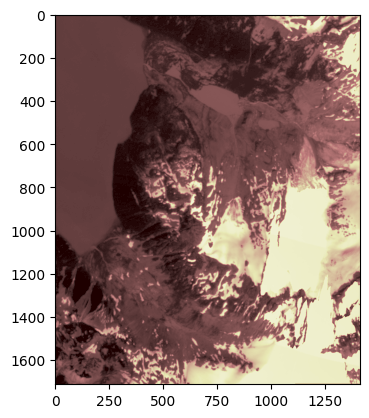

In [17]:
# displaying bands from the satellite image

from matplotlib import pyplot
sat = rio.open(satellite2)

def display_band(sat_band):
  pyplot.imshow(sat.read(sat_band), cmap='pink')

display_band(2)

In [18]:
# ilterating over multiband raster
sampled = pd.Series()

#inputShape= temp_point_loc
# Read input shapefile with fiona and iterate over each feature
with fiona.open(temp_point_loc) as shp:
    for feature in shp:
        siteID = feature['properties']['num_class']
        coords = feature['geometry']['coordinates']
        # Read pixel value at the given coordinates using Rasterio
        # NB: `sample()` returns an iterable of ndarrays.
        with rio.open(satellite2) as stack_src:
                  value = [v for v in stack_src.sample([coords])]
        # Update the pandas serie accordingly
        sampled.loc[siteID] = value

# reshaping sampled values
df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['num_class'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(),
                   columns=features)
df1['num_class'] = df1.index

data = pd.merge(df1, points_df, on ='num_class')
print('Sampled Data: \n',data)

<ipython-input-18-31bb39cffd97>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sampled = pd.Series()


Sampled Data: 
         band1  band2  band3  band4  band5  band6  band7  band8  num_class  \
0         813    818   1027   1151   1260   1232   1478   2553          0   
1         813    818   1027   1151   1260   1232   1478   2553          0   
2         813    818   1027   1151   1260   1232   1478   2553          0   
3         813    818   1027   1151   1260   1232   1478   2553          0   
4         813    818   1027   1151   1260   1232   1478   2553          0   
...       ...    ...    ...    ...    ...    ...    ...    ...        ...   
107577   6075   5920   6431   6733   7147   6758   6699   5614         12   
107578   6075   5920   6431   6733   7147   6758   6699   5614         12   
107579   6075   5920   6431   6733   7147   6758   6699   5614         12   
107580   6075   5920   6431   6733   7147   6758   6699   5614         12   
107581   6075   5920   6431   6733   7147   6758   6699   5614         12   

           id  
0       13266  
1       13267  
2       132

In [19]:
x = data.iloc[:,0:f_len]
X = x.values
y = data.iloc[:,-2]
Y = y.values

print(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, stratify = Y)

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

[[ 813  818 1027 ... 1232 1478 2553]
 [ 813  818 1027 ... 1232 1478 2553]
 [ 813  818 1027 ... 1232 1478 2553]
 ...
 [6075 5920 6431 ... 6758 6699 5614]
 [6075 5920 6431 ... 6758 6699 5614]
 [6075 5920 6431 ... 6758 6699 5614]]
X_train Shape: (75307, 8)
X_test Shape: (32275, 8)
y_train Shape: (75307,)
y_test Shape:(32275,)


In [20]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
cName = 'SVM'
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)

clf_pred = clf.predict(X_test)

print(f"Accuracy {cName}: {accuracy_score(y_test, clf_pred)*100}")
print(classification_report(y_test, clf_pred))


Accuracy SVM: 99.43299767621998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1067
           2       1.00      1.00      1.00     15474
           3       1.00      1.00      1.00        65
           4       1.00      1.00      1.00       165
           5       1.00      1.00      1.00       257
           6       1.00      1.00      1.00       440
           7       1.00      1.00      1.00      3098
           8       1.00      1.00      1.00       281
           9       0.96      1.00      0.98      4037
          10       0.00      0.00      0.00       183
          11       1.00      1.00      1.00       514
          12       1.00      1.00      1.00      6694

    accuracy                           0.99     32275
   macro avg       0.91      0.92      0.91     32275
weighted avg       0.99      0.99      0.99     32275



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
#confusion matrix

cm = confusion_matrix(y_test, clf_pred)
print('Confusion Matrix RF: \n',cm)
cm_percent = (100 * (cm/np.sum(cm)))

print(cm_percent)

Confusion Matrix RF: 
 [[ 1067     0     0     0     0     0     0     0     0     0     0     0]
 [    0 15474     0     0     0     0     0     0     0     0     0     0]
 [    0     0    65     0     0     0     0     0     0     0     0     0]
 [    0     0     0   165     0     0     0     0     0     0     0     0]
 [    0     0     0     0   257     0     0     0     0     0     0     0]
 [    0     0     0     0     0   440     0     0     0     0     0     0]
 [    0     0     0     0     0     0  3098     0     0     0     0     0]
 [    0     0     0     0     0     0     0   281     0     0     0     0]
 [    0     0     0     0     0     0     0     0  4037     0     0     0]
 [    0     0     0     0     0     0     0     0   183     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0   514     0]
 [    0     0     0     0     0     0     0     0     0     0     0  6694]]
[[ 3.30596437  0.          0.          0.          0.          0.
   0.     

In [24]:
%%time
cName = 'SVM_new'
exp_name = f'/content/drive/MyDrive/PIXELS_python/Data{cName}.tif'


img = rio.open(satellite2)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, f_len)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

Height: 1712
Width: 1412
Bands: 8

reshaped full data shape  for prediction:  (2417344, 8)
CPU times: user 575 ms, sys: 45.4 ms, total: 620 ms
Wall time: 741 ms


In [25]:
pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)


out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1, # output band number
                                          dtype='uint8', #output data type
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

Prediction Done, now exporting raster 



NameError: ignored